# Random forest

In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

In [2]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predicand)

In [3]:
dem_da = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_stl.nc"
)["demand_stl"]

Predictors. Load everything from relevant directory.

In [4]:
files = [path + "demand_predictors/" + i for i in os.listdir(path + "demand_predictors/")]

In [5]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [6]:
pred_ds.data_vars

Data variables:
    msdwswrf  (region, time) float64 307.1 284.8 286.2 ... 287.8 227.2 297.5
    hdd       (region, time) float64 0.6528 0.5974 0.6455 ... 4.369 2.011 0.4213
    mtpr      (region, time) float64 2.842e-05 4.244e-05 ... 1.614e-05 6.045e-06
    q         (region, time) float64 10.45 10.46 10.05 ... 6.65 9.337 10.11
    hdd3      (region, time) float64 nan nan 0.7969 0.657 ... 2.98 3.604 2.16
    t2m4      (region, time) float64 nan nan nan 299.3 ... 289.8 289.3 288.2
    w10       (region, time) float64 3.489 3.602 3.166 ... 1.758 3.059 3.369
    t2m       (region, time) float64 294.9 294.4 294.8 ... 286.7 289.1 291.1
    t2min     (region, time) float64 nan 293.3 293.8 294.0 ... 282.5 287.1 287.3
    rh        (region, time) float64 72.35 69.38 69.15 ... 65.67 76.73 71.14
    t2max     (region, time) float64 nan 304.6 305.0 306.3 ... 290.4 292.4 295.5
    cdd4      (region, time) float64 nan nan nan ... 0.08498 0.08498 0.000234
    t2m3      (region, time) float64 nan na

### Just work with two predictors for now

In [7]:
pred_ds = pred_ds[["t2m", "t2max"]]

## Prepare data

For a given region, get the data into a dataframe

In [8]:
def to_dataframe(target_da, predictors_ds, region):
    """
    Convert xarray data to pandas dataframe.
    """
    # Predictors to array
    predictors_arr = predictors_ds.sel(region=region, time=target_da["time"]).to_array("variable")
    
    # Data array of target and predictors
    da = xr.concat([
        predictors_arr,
        target_da.sel(region=region).expand_dims({"variable": ["demand"]})
    ],
        dim="variable"
    )
    
    # Dataframe
    df = pd.DataFrame(
        da.transpose(),
        columns=da["variable"],
        index=target_da["time"]
    )
    
    return df

Set up a time column to either indicate:
1. day of week
2. weekend/weekday binary
3. winter/summer/transition
4. transition/(winter,summer) binary

In [9]:
def add_time_column(df, method):
    """
    Add a time column to df.
    
    df: dataframe to add to
    method: str indicating which method to use. Currently 'is_weekend',
            'month_sin', 'month_cos', 'month_int', 'season_int'
    """
    if method == "is_weekend":
        # Bool for weekend day or weekday
        new_col = (df.index.weekday > 4).astype("int16")
    elif method == "is_transition":
        new_col = df.index.month.isin([3, 4, 5, 9, 10, 11])
    elif method == "month_sin":
        new_col = np.sin((df.index.month - 1) * (2. * np.pi / 12))
    elif method == "month_cos":
        new_col = np.cos((df.index.month - 1) * (2. * np.pi / 12))
    elif method == "month_int":
        new_col = df.index.month
    elif method == "season_int":
        new_col = df.index.month % 12 // 3 + 1
    else:
        raise ValueError("Incorrect 'method'.")
    
    df[method] = new_col
    return df

*Note:* I've tried various permutations of seasonal indices (months and seasons), but they are all of low variable importance. This is presumably because seasonal information is contained in temperature.

In [10]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
time_cols = ["is_weekend"]

region_dfs = {}
for region in dem_da.region.values:
    df = to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [11]:
region_dfs["NEM"].head()

,demand,is_weekend,t2m,t2max
2010-01-01,-41100.149287,0,295.592025,303.550399
2010-01-02,19560.909302,1,294.383226,302.166075
2010-01-03,-6000.400994,1,294.179263,302.026736
2010-01-04,-24359.584905,0,295.617390,303.514904
2010-01-05,-29769.122085,0,296.451681,304.407560


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [12]:
def split(df, target_name, test_size, random_state, shuffle=True):
    """
    Apply train_test_split to dataframe
    
    df: pandas dataframe
    target_name: column name of df to target
    test_size: float, proportion of data to test
    random_state: int
    shuffle: bool, whether or not to shuffle data before splitting
    """
    y = np.array(df[target_name]) # target
    X = np.array(df.drop(target_name, axis=1)) # predictors
    return train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)

In [13]:
len(region_dfs["NEM"])

4017

In [14]:
# Hold out last two years for testing
test_len = dem_da.sel(time=slice("2019", "2020")).time.values.shape[0]

In [15]:
test_len

730

In [16]:
train_X, test_X, train_y, test_y = split(
    region_dfs["NEM"],
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [17]:
def leave_one_group_out(train_X, train_y, target_da, first_year, last_year):
    """
    Return CV splitter using leave one group out, where the groups are years.
    
    train_X: training data
    train_y: training target
    target_da: target array with time dimension
    first_year, last_year: str, first and last years of training set
    """
    logo = LeaveOneGroupOut()
    groups = target_da.sel(time=slice(first_year, last_year)).time.dt.year.values
    return logo.split(train_X, train_y, groups=groups)

In [18]:
def tune_hyperparameters(train_X, train_y, parameters, cv, n_iter, random_state=0):
    """
    Return tuned hyperparameters by fitting the model using CV on the training set.
    
    train_X: training data
    train_y: training target
    parameters: dict, parameters of RandomForestRegressor to tune, with associated distributions
    cv: the cross validation to do. See docs for RandomizedSearchCV
    random_state: random state for RandomizedSearchCV
    n_iter: number of CV iterations
    """
    rf = RandomForestRegressor()
    clf = RandomizedSearchCV(rf, parameters, cv=cv, n_iter=n_iter, random_state=random_state)
    search = clf.fit(train_X, train_y)
    return search.best_params_

In [19]:
# parameters = {
#     "n_estimators": randint(10, 500), # no. trees in the forest
#     "min_samples_leaf": randint(1, 30), # min no. samples at leaf node
#     "max_depth" : randint(5, 100), # max depth of each tree
#     # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
# }

In [20]:
# very restricted space for testing
parameters = {
    "n_estimators": randint(2, 3), # no. trees in the forest
}

In [21]:
logo = leave_one_group_out(train_X, train_y, dem_da, "2010", "2018")

In [22]:
best_params = tune_hyperparameters(train_X, train_y, parameters, logo, n_iter=1, random_state=0)

In [23]:
best_params

{'n_estimators': 2}

## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [44]:
def sfs(train_X, train_y, rf, cv, tol=0.001, scoring="neg_root_mean_squared_error"):
    """
    Forward selection of features using CV, and a chosen score with tolerance.
    
    train_X: training data
    train_y: training target
    rf: RandomForestRegressor
    cv: the cross validation to do. See docs for RandomizedSearchCV
    tol: tolerance for scoring
    scoring: score to use in CV
    """
    s = SequentialFeatureSelector(rf, tol=tol, scoring=scoring, cv=cv)
    return s.fit(train_X, train_y)

In [42]:
rf = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    random_state=0
)

In [43]:
logo = leave_one_group_out(train_X, train_y, dem_da, "2010", "2018")

In [45]:
model = sfs(train_X, train_y, rf, logo)

In [57]:
selected_features = list(region_dfs["NEM"].columns[1:][model.get_support()])
print(selected_features)

['is_weekend']


## Finalise best model

In [58]:
retain = ["demand"] + selected_features

In [61]:
final_features = region_dfs["NEM"][retain]

In [63]:
train_X, test_X, train_y, test_y = split(
    final_features,
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [65]:
rf = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    random_state=0
)

In [66]:
def predict_forest(train_y, train_X, test_X, rf):
    """
    Instantiate and fit a random forest model, return predictions.
    
    train_y: target for training set
    train_X: predictors for training set
    test_X: predictors for test set
    rf: RandomForestRegressor
    """
    rf.fit(train_X, train_y)
    return rf, rf.predict(test_X)

In [67]:
model, pred_train = predict_forest(train_y, train_X, train_X, rf)

In [68]:
model, pred_test = predict_forest(train_y, train_X, test_X, rf)

In [69]:
pred_train.shape

(3287,)

In [70]:
pred_test.shape

(730,)

## Train model and make predictions

In [16]:
def compute_scores(y_true, y_pred, metrics):
    """
    Compute scores for a variety of metrics.
    
    y_true: observations
    y_predict: predictions
    metrics: list of scores from sklearn.metrics
    """
    scores = []
    for metric in metrics:
        s = metric(y_true, y_pred)
        scores.append(s)
    return scores

In [17]:
def dropcol(df, to_drop):
    """
    Drop columns from df
    """
    return df.drop(to_drop, axis=1)

In [18]:
def rf_repeat(df, metrics, n_splits, n_runs, shuffle=True):
    """
    Fit a random forest n_runs times to n_splits of data and compute importances and scores.
    """
    # Predictors
    pred_list = df.drop("demand", axis=1).columns
    
    # Empty arrays or lists to fill with results
    test_values = []
    predictions_list = []
    importances = np.zeros((n_splits, n_runs, len(pred_list)))
    scores_arr = np.zeros((n_splits, n_runs, len(metrics)+1))
    
    for i in range(n_splits):
        
        train_X, test_X, train_y, test_y = split(
            df,
            "demand",
            test_size=0.2,
            random_state=i,
            shuffle=shuffle
        )
        
        p = []
        for j in range(n_runs):
            rf, predictions = predict_forest(
                train_y,
                train_X,
                test_X,
                random_state=j,
                n_estimators=100,
                n_jobs=5
            )
            p.append(predictions)
        
            # predictions_list.append(predictions)
            importances[i, j, :] = rf.feature_importances_
            scores = compute_scores(test_y, predictions, metrics)
            # Also compute correlation
            cor, _ = pearsonr(test_y, predictions)
            scores.append(cor)
            scores_arr[i, j, :] = scores
            
        predictions_list.append(np.array(p))
        test_values.append(test_y)
        
    # test_values and predictions_list to array
    test_values_arr = np.array(test_values)
    predictions_arr = np.array(predictions_list)
        
    return test_values_arr, predictions_arr, importances, scores_arr

In [19]:
n_splits = 100
n_runs = 1

In [20]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE", "r"]
metrics = [r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

Only need importances for now

In [23]:
%%time
_test_ys, _preds, importances, _scores = rf_repeat(region_dfs["NEM"], metrics, n_splits, n_runs, shuffle=True)

CPU times: user 5min 54s, sys: 13.3 s, total: 6min 7s
Wall time: 3min 10s


In [32]:
def plot_importances(df, importances):
    """
    Boxplot that ranks importances
    """
    n = importances.shape[0]
    # Sort by mean of all runs
    _means = importances.mean(axis=(0, 1))
    _argsort = np.flip(np.argsort(_means))
    vals_sorted = importances[:, :, _argsort]
    vals_sorted = vals_sorted.reshape(-1, vals_sorted.shape[-1])
    names_sorted = df.drop("demand", axis=1).columns[_argsort]
    
    fig, ax = plt.subplots()
    _ = ax.boxplot(vals_sorted)
    _ = ax.set_xticklabels(names_sorted, rotation=90)
    ax.set_title("Variable importances ("+str(n)+" splits)")
    
    return names_sorted

### Shuffled split

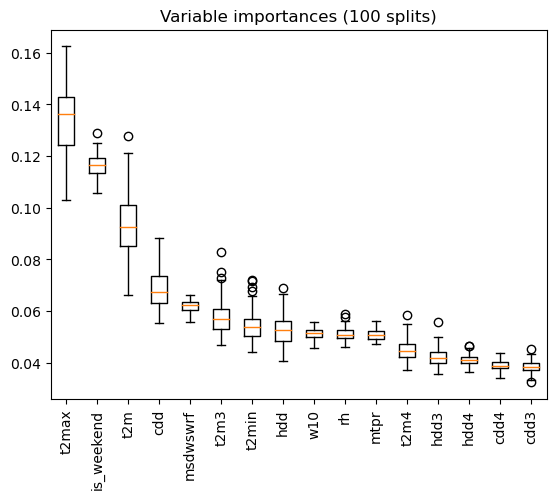

In [33]:
sorted_preds = plot_importances(region_dfs["NEM"], importances)

### Un-shuffled split

In [26]:
# sorted_preds = plot_importances(region_dfs["NEM"], importances)

### Now we want to fit models but dropping the least important predictors

In [27]:
sorted_importances = np.flip(sorted_preds)
to_drop = []
    
# Drop least important, then the two least important etc.
for i in range(len(sorted_importances)):
    to_drop.append(sorted_importances[:i])

In [28]:
n_models = len(to_drop)

In [29]:
to_drop[:3]

[Index([], dtype='object'),
 Index(['cdd3'], dtype='object'),
 Index(['cdd3', 'cdd4'], dtype='object')]

In [30]:
_preds.shape

(100, 1, 804)

In [31]:
load = False

In [36]:
shuffle = True
n_splits = 100

In [37]:
%%time
if load:
    da_importances = xr.open_dataset(path + "/random_forest/importances_" + str(n_splits) + "_splits_" + str(n_runs) + "_runs_NEM.nc")
    da_test_ys = xr.open_dataset(path + "/random_forest/test_data_" + str(n_splits) + "_splits_" + str(n_runs) + "_runs_NEM.nc")
    da_preds = xr.open_dataset(path + "/random_forest/predictions_" + str(n_splits) + "_splits_" + str(n_runs) + "_runs_NEM.nc")
    da_scores = xr.open_dataset(path + "/random_forest/scores_" + str(n_splits) + "_splits_" + str(n_runs) + "_runs_NEM.nc")
else:
    df = region_dfs["NEM"]

    test_ys = np.zeros((n_models, _test_ys.shape[0], _test_ys.shape[-1]))
    preds = np.zeros((n_models, _preds.shape[0], _preds.shape[1], _preds.shape[-1]))
    imps = [] #np.zeros((n_models, importances.shape[0], importances.shape[-1]))
    scores = np.zeros((n_models, _scores.shape[0], _scores.shape[1], _scores.shape[-1]))

    for i, d in enumerate(to_drop):
        # print(i)
        _df = dropcol(df, d)    
        y, p, imp, s = rf_repeat(_df, metrics, n_splits, n_runs, shuffle=shuffle)
        test_ys[i,:,:] = y
        preds[i,:,:,:] = p
        # imps[i,:,:] = imp
        imps.append(imp)
        scores[i,:,:,:] = s
        # models.append((y, p, imp, s))

    da_importances = xr.DataArray(
        np.array(importances),
        dims=["model", "split", "predictor"],
        coords={"model": range(len(importances)),
                "split": range(importances[0].shape[0]),
                "predictor": range(importances[0].shape[-1])}
    )
    da_importances = da_importances.to_dataset(name="importance")
    fn = path + "/random_forest/importances_" + str(n_splits) + "_splits_" + str(n_runs) + "_runs_NEM"
    if shuffle:
        fn = fn + "_shuffled"
    da_importances.to_netcdf(fn + ".nc")

    da_test_ys = xr.DataArray(
        test_ys,
        dims=["model", "split", "time"],
        coords={"model": range(n_models),
                "split": range(test_ys.shape[1]),
                "time": range(test_ys.shape[-1])}
    )
    da_test_ys = da_test_ys.to_dataset(name="test_data")
    fn = path + "/random_forest/test_data_" + str(n_splits) + "_splits_" + str(n_runs) + "_runs_NEM"
    if shuffle:
        fn = fn + "_shuffled"
    da_test_ys.to_netcdf(fn + ".nc")

    da_preds = xr.DataArray(
        preds,
        dims=["model", "split", "run", "time"],
        coords={"model": range(preds.shape[0]),
                "split": range(preds.shape[1]),
                "run": range(preds.shape[2]),
                "time": range(preds.shape[-1])}
    )
    da_preds = da_preds.to_dataset(name="predictions")
    fn = path + "/random_forest/predictions_" + str(n_splits) + "_splits_" + str(n_runs) + "_runs_NEM"
    if shuffle:
        fn = fn + "_shuffled"
    da_preds.to_netcdf(fn + ".nc")

    da_scores = xr.DataArray(
        scores,
        dims=["model", "split", "run", "score"],
        coords={"model": range(scores.shape[0]),
                "split": range(scores.shape[1]),
                "run": range(scores.shape[2]),
                "score": metric_names}
    )
    da_scores = da_scores.to_dataset(name="scores")
    fn = path + "/random_forest/scores_" + str(n_splits) + "_splits_" + str(n_runs) + "_runs_NEM"
    if shuffle:
        fn = fn + "_shuffled"
    da_scores.to_netcdf(fn + ".nc")

CPU times: user 50min 4s, sys: 3min 30s, total: 53min 34s
Wall time: 28min 29s


In [38]:
len(range(len(sorted_importances), 0, -1))

16

In [39]:
da_scores["score"].shape

(6,)

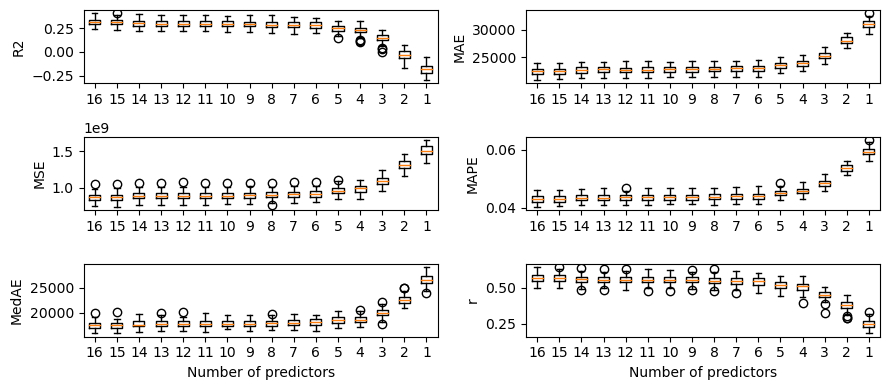

In [112]:
fig, ax = plt.subplots(len(metric_names)//2, 2, figsize=(9,4))
for i in range(len(metric_names)):
    _scores = da_scores["__xarray_dataarray_variable__"].data[:,:,:,i].transpose().reshape(-1, len(sorted_importances))

    a = ax.flatten()[i]

    _ = a.boxplot(_scores)
    a.set_xticklabels(range(len(sorted_importances), 0, -1))
    
    a.set_ylabel(metric_names[i])
    
ax[-1,0].set_xlabel("Number of predictors")
ax[-1,1].set_xlabel("Number of predictors")
plt.tight_layout()

### Shuffled, demand resids after STL

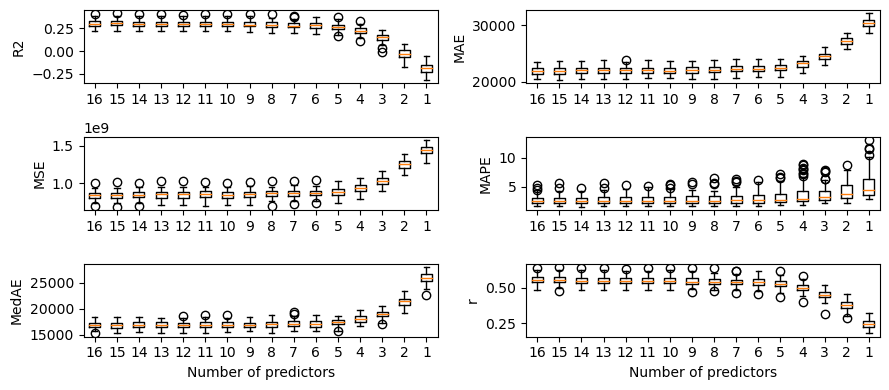

In [ ]:
fig, ax = plt.subplots(len(metric_names)//2, 2, figsize=(9,4))
for i in range(len(metric_names)):
    _scores = da_scores["scores"].data[:,:,:,i].transpose().reshape(-1, len(sorted_importances))

    a = ax.flatten()[i]

    _ = a.boxplot(_scores)
    a.set_xticklabels(range(len(sorted_importances), 0, -1))
    
    a.set_ylabel(metric_names[i])
    
ax[-1,0].set_xlabel("Number of predictors")
ax[-1,1].set_xlabel("Number of predictors")
plt.tight_layout()

### Unshuffled splits (only 1 run)

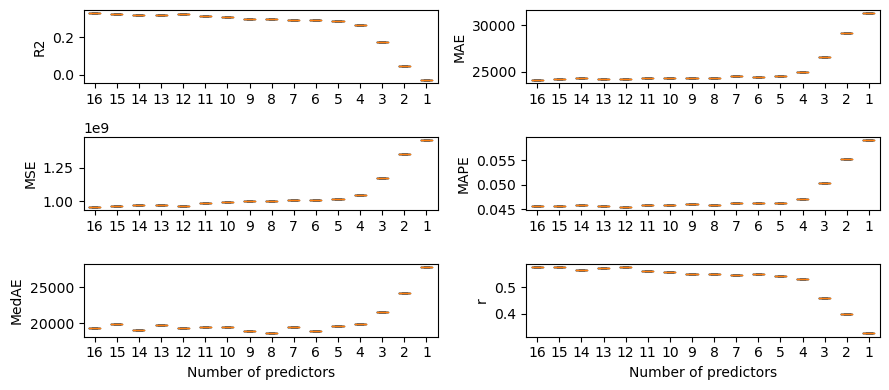

In [53]:
fig, ax = plt.subplots(len(metric_names)//2, 2, figsize=(9,4))
for i in range(len(metric_names)):
    _scores = da_scores["scores"].data[:,:,:,i].transpose().reshape(-1, len(sorted_importances))

    a = ax.flatten()[i]

    _ = a.boxplot(_scores)
    a.set_xticklabels(range(len(sorted_importances), 0, -1))
    
    a.set_ylabel(metric_names[i])
    
ax[-1,0].set_xlabel("Number of predictors")
ax[-1,1].set_xlabel("Number of predictors")
plt.tight_layout()

In [54]:
def ts_scatter(ax0, ax1, obs, pred, model_label):
    """
    Time series and scatter plot of predictions against obs
    """
    ax0.plot(obs/1000, label="Obs", lw=0.7, alpha=0.7)
    ax0.plot(pred/1000, label=model_label, lw=0.7, alpha=0.7)
    ax0.legend()
    ax0.set_ylabel("Demand [GWh/day]")

    ax1.scatter(pred/1000, obs/1000, s=12, alpha=0.7)
    ax1.plot(np.arange(4.5e2, 6.5e2, 10), np.arange(4.5e2, 6.5e2, 10), color="k", ls="--")
    ax1.set_xlabel("Predicted [GWh/day]")
    ax1.set_ylabel("Observed [GWh/day]")

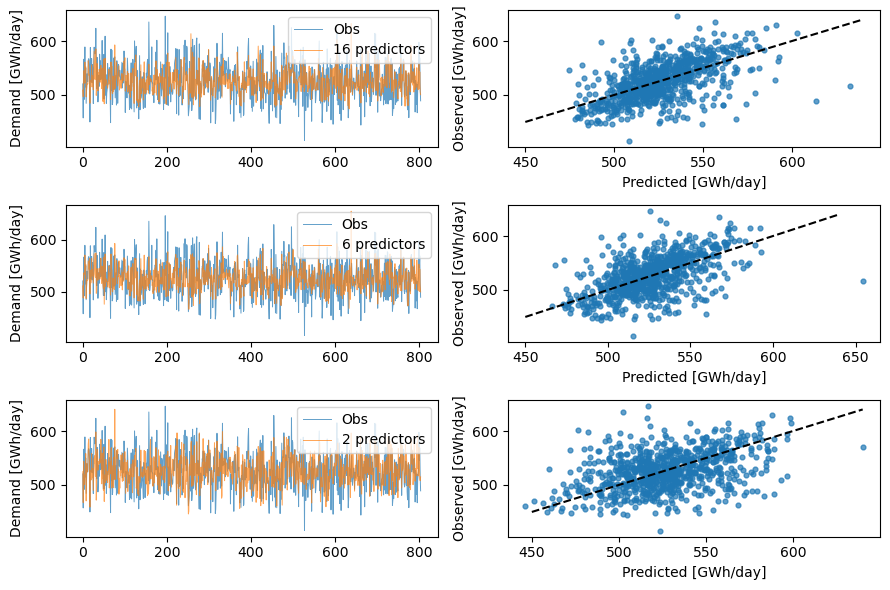

In [127]:
fig, ax = plt.subplots(3, 2, figsize=(9, 6))

for i, (o, p, l) in enumerate(zip(
    [
        da_test_ys["__xarray_dataarray_variable__"].data[0,0,:],
        da_test_ys["__xarray_dataarray_variable__"].data[-6,0,:],
        da_test_ys["__xarray_dataarray_variable__"].data[-2,0,:]
    ],
    [
        da_preds["__xarray_dataarray_variable__"].data[0,0,0,:],
        da_preds["__xarray_dataarray_variable__"].data[-6,0,0,:],
        da_preds["__xarray_dataarray_variable__"].data[-2,0,0,:]
    ],
    ["16 predictors", "6 predictors", "2 predictors"]
)):
    ts_scatter(ax[i,0], ax[i,1], o, p, l)
plt.tight_layout()

### Unshuffled

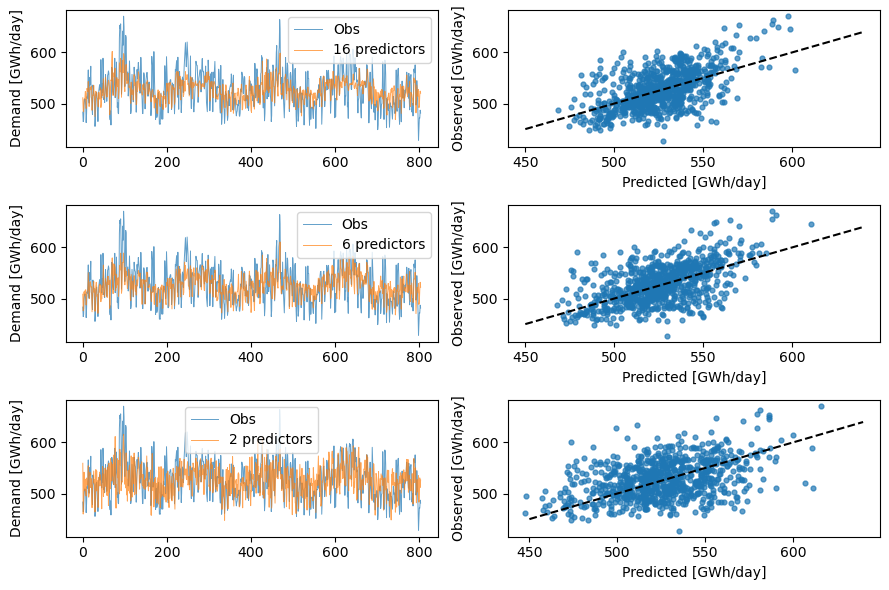

In [57]:
fig, ax = plt.subplots(3, 2, figsize=(9, 6))

for i, (o, p, l) in enumerate(zip(
    [
        da_test_ys["test_data"].data[0,0,:],
        da_test_ys["test_data"].data[-6,0,:],
        da_test_ys["test_data"].data[-2,0,:]
    ],
    [
        da_preds["predictions"].data[0,0,0,:],
        da_preds["predictions"].data[-6,0,0,:],
        da_preds["predictions"].data[-2,0,0,:]
    ],
    ["16 predictors", "6 predictors", "2 predictors"]
)):
    ts_scatter(ax[i,0], ax[i,1], o, p, l)
plt.tight_layout()

### Remove weekends and Xmas

In [37]:
df = region_dfs["NEM"]

In [39]:
df = df[df.index.dayofweek < 5]

In [50]:
excl1 = df.loc[(df.index.month == 12) & (df.index.day > 20)].index

In [51]:
excl2 = df.loc[(df.index.month == 1) & (df.index.day < 7)].index

In [52]:
df = df.loc[~df.index.isin(excl1)]

In [53]:
df = df.loc[~df.index.isin(excl2)]

In [55]:
df = df.drop("is_weekend", axis=1)

In [56]:
df.head()

,demand,t2min,t2m3,msdwswrf,cdd4,t2m,cdd3,cdd,hdd4,hdd,mtpr,rh,w10,t2max,hdd3,t2m4
2010-01-07,565945.324033,290.415369,294.414131,273.510759,0.244000,294.441042,0.287709,0.312273,0.360762,0.145529,0.000020,90.331835,2.363458,298.347744,0.416291,294.280430
2010-01-08,524425.379396,292.352803,295.378893,301.187294,0.564582,297.694344,0.669831,1.306739,0.344375,-0.009270,0.000010,86.646956,2.608405,302.421511,0.375149,295.234239
2010-01-11,516423.655484,296.133402,299.015017,317.888766,2.207097,300.909725,2.477729,3.996856,0.137702,-0.010805,0.000002,84.330584,3.338275,305.699808,0.140728,298.684902
2010-01-12,536580.745846,292.100818,298.629081,273.239414,2.274071,297.049598,2.396077,1.523748,0.164157,0.104504,0.000014,89.737635,3.090985,305.242717,0.166626,298.523717
2010-01-13,559178.981209,289.955587,297.157821,288.832984,1.888047,293.513647,2.053116,0.318313,0.339337,0.791076,0.000009,90.947086,3.616589,298.416706,0.406570,297.350274


In [57]:
%%time
_test_ys, _preds, importances, _scores = rf_repeat(df, metrics, n_splits, n_runs)

CPU times: user 3min 59s, sys: 7.29 s, total: 4min 7s
Wall time: 2min 10s


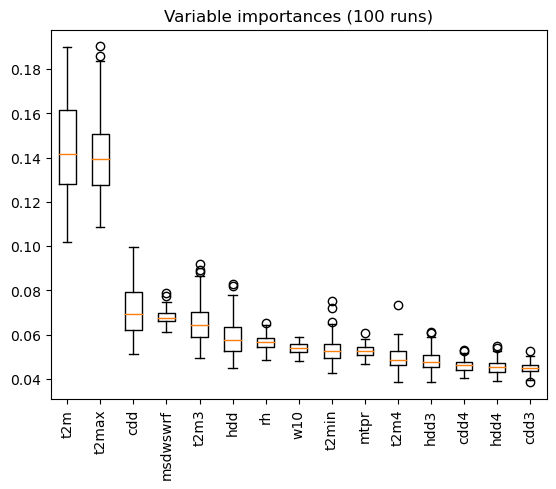

In [58]:
sorted_preds = plot_importances(df, importances)

In [61]:
metric_names

['R2', 'MAE', 'MSE', 'MAPE', 'MedAE', 'r']

In [63]:
_scores.shape

(100, 1, 6)

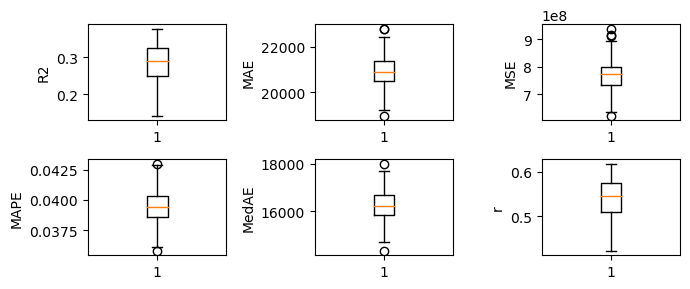

In [72]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))
for i in range(6):
    ax.flatten()[i].boxplot(_scores[:,0,i])
    ax.flatten()[i].set_ylabel(metric_names[i])
plt.tight_layout()